# Make PIK3CA Figure 2

This notebook finds the effect of PIK3CA hotspot mutations on trans phosphosites. It then plots the box plot comparison for the significant sites. It first looks at the 62 sites that were found to be stat. significant in the mertins paper and then looks at sites just with in the pik3ca pathway. 

In [1]:
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import re
import statsmodels.stats.multitest
import operator
import cptac.utils as u
import cptac
import warnings
warnings.filterwarnings('ignore')

/Users/Lindsey/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
cptac warning: Your version of cptac (0.8.2) is out-of-date. Latest is 0.8.4. Please run 'pip install --upgrade cptac' to update it. (/Users/Lindsey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py, line 9)


# Load cptac data 

Breast, endometrial, and colon cancer are the three cancers that have pik3ca hotspot mutations

In [2]:
br = cptac.Brca()
endo = cptac.Endometrial()
col = cptac.Colon()

In [38]:
#Read in table that has 62 sites that are significant. 
brca1_pvals = pd.read_csv('../Brca_mertins_pvals.csv')

brca1_pvals = brca1_pvals.replace(r' ', "", regex = True)
brca1_pvals = brca1_pvals.replace(r'[a-z]', "", regex = True)

phospho_sites = brca1_pvals.Comparison.to_list()
phospho_sites.append("PIK3CA_Location")
phospho_sites.append("PIK3CA_Mutation")


In [57]:
def get_trans_results(cancer, phos_list , prot_names = True, return_result_df = True):
    phos = cancer.join_omics_to_mutations(omics_df_name = "phosphoproteomics",mutations_genes="PIK3CA", tissue_type="tumor")
    if cancer == br:
        phos = u.reduce_multiindex(df=phos, levels_to_drop=["Database_ID","Peptide"])
    if cancer == col:
        phos = u.reduce_multiindex(df=phos, levels_to_drop=["Database_ID"])
    
    if prot_names:
        genefilter = phos.columns.get_level_values("Name").isin(phos_list)
        phos_pik3ca = phos[phos.columns[genefilter]]
        phos_pik3ca = cptac.utils.reduce_multiindex(phos_pik3ca, flatten=True)
        
    if prot_names == False:
        phos = cptac.utils.reduce_multiindex(phos, flatten=True)
        phos.columns = phos.columns.str.replace("_phosphoproteomics", "")
        genefilter = phos.columns.isin(phos_list)
        phos_pik3ca = phos[phos.columns[genefilter]]


    phos_pik3ca['PIK3CA_Mutation'] = [','.join(map(str, l)) for l in phos_pik3ca['PIK3CA_Mutation']]
    phos_pik3ca['PIK3CA_Location'] = [','.join(map(str, l)) for l in phos_pik3ca['PIK3CA_Location']]
    phos_pik3ca  = rename_duplicate_cols(phos_pik3ca)
    hotspot = phos_pik3ca[(phos_pik3ca.PIK3CA_Location.str.contains('E542K'))| 
                    phos_pik3ca.PIK3CA_Location.str.contains('E545K')| 
                    phos_pik3ca.PIK3CA_Location.str.contains('H1047R')]
    hotspot["PIK3CA_Mutation"] = "Hotspot"
    wt = phos_pik3ca[(phos_pik3ca.PIK3CA_Mutation.str.contains('Wildtype'))]
    hotspot_wt = pd.concat([hotspot, wt])
    if return_result_df:

        cols = hotspot_wt.columns.to_list()
        cols.remove("PIK3CA_Mutation")
        cols.remove("PIK3CA_Location")
        print("n sites = " + str(len(cols)))
        phos_pval = u.wrap_ttest(hotspot_wt, 'PIK3CA_Mutation', cols,return_all=True, pval_return_corrected= True, correction_method= "FDR_bh")
        return phos_pval
    else:
        return hotspot_wt
    

In [25]:
def rename_duplicate_cols(df):
    cols = pd.Series(df.columns[:])

    for dup in cols[cols.duplicated()].unique(): 
        cols[cols[cols == dup].index.values.tolist()] = [dup + '_' + str(i) if i != 0 else dup for i in range(sum(cols == dup))]

    # rename the columns with the cols list.
    df.columns=cols
    return df

# Run Wrap t-test for three cancers for the 62 proteins that were significant. 

In [80]:
brca_results = get_trans_results(br,phospho_sites, prot_names=False)
brca_results.head(10)

n sites = 37


,Comparison,P_Value
0,MED26_T426,0.037994
1,NFIA_S300S319,0.037994
2,RPS6KA5_S212,0.053179
3,TRIM28_S489,0.053179
4,TSC22D3_S73,0.053179
5,SPAG7_S202,0.076446
6,GTF2F1_T427,0.084079
7,DDX17_S573,0.130020
8,RTF1_S697,0.130020
9,FAM21A_S836,0.130020


In [81]:
endo_results = get_trans_results(endo,phospho_sites, prot_names=False)
endo_results.head(10)

n sites = 32


,Comparison,P_Value
0,METTL3_S43,0.154598
1,EIF2AK4_S572,0.312406
2,RBM10_S596,0.758115
3,RPS6KA5_S212,0.758115
4,SPAG7_S202,0.758115
5,SRRT_S136,0.758115
6,RAVER1_S584,0.758115
7,FIP1L1_T221,0.758115
8,DTNBP1_S11,0.758115
9,DDX17_S573,0.758115


In [82]:
colon_results = get_trans_results(col,phospho_sites,prot_names=False)
colon_results

n sites = 17


,Comparison,P_Value
0,ARHGEF35_S450,0.041890
1,HUWE1_S1368,0.041890
2,RTF1_S697,0.163582
3,TRIM28_S489,0.163582
4,KHDRBS1_S20,0.250245
5,KRT8_S475,0.250245
6,SRRT_S136,0.275867
7,WWC3_S957,0.890064


# Run wrap t-test on pik3ca pathway

In [83]:
# Get Pik3ca pathway proteins
prot = u.get_proteins_in_pathways('PI3K-Akt Signaling Pathway', 'wikipathways')
prot_list = list(prot.member)
phos_list = ["PIK3CA_Location","PIK3CA_Mutation"]
for gene in prot_list:
    phos = gene + "_phosphoproteomics"
    phos_list.append(phos)


In [84]:
brca_results = get_trans_results(br,phos_list)
brca_results

n sites = 636


,Comparison,P_Value
0,AKT2_phosphoproteomics_S34,0.048497
1,FOXO3_phosphoproteomics_T32,0.075094
2,MAP2K2_phosphoproteomics_S306,0.175429
3,GSK3B_phosphoproteomics_S9,0.175429
4,FOXO3_phosphoproteomics_S253,0.175429
...,...,...
629,CREB1_phosphoproteomics_S340,0.995932
630,BRCA1_phosphoproteomics_S1497,0.995932
631,MAP2K2_phosphoproteomics_S222S226,0.995932
632,BAD_phosphoproteomics_S146,0.997340


In [85]:
Endo_results = get_trans_results(endo,phos_list)
Endo_results

n sites = 1281


,Comparison,P_Value
0,AKT1_phosphoproteomics_S124,0.997742
1,PKN2_phosphoproteomics_T124,0.997742
2,PKN2_phosphoproteomics_T364,0.997742
3,PKN2_phosphoproteomics_T533,0.997742
4,PKN2_phosphoproteomics_T628,0.997742
...,...,...
718,HSP90AB1_phosphoproteomics_S255,0.997742
719,HSP90AB1_phosphoproteomics_S261,0.997742
720,HSP90AB1_phosphoproteomics_S445,0.997742
721,HSP90AB1_phosphoproteomics_S587,0.997742


In [86]:
col_results = get_trans_results(col,phos_list)
col_results

n sites = 620


,Comparison,P_Value
0,TSC2_phosphoproteomics_S1420,0.255116
1,EGFR_phosphoproteomics_Y1092,0.602252
2,IRS1_phosphoproteomics_S636,0.732574
3,NFKB1_phosphoproteomics_S937,0.732574
4,PDGFRB_phosphoproteomics_S705,0.732574
...,...,...
255,SOS2_phosphoproteomics_S1315,0.997479
256,PKN2_phosphoproteomics_S306,0.997479
257,MAP2K2_phosphoproteomics_S293,0.997479
258,MYC_phosphoproteomics_S62,0.997479


In [102]:
#First get proteomic df for 62 sites 
Colon_trans_df =  get_trans_results(col,phospho_sites,prot_names= False, return_result_df=False)
Brca_trans_df =  get_trans_results(br,phospho_sites,prot_names= False,return_result_df=False)
Endo_trans_df =  get_trans_results(endo,phospho_sites,prot_names= False,return_result_df=False)

#get proteomic df for pik3ca pathway

Colon_trans_df_path =  get_trans_results(col,phos_list,return_result_df=False)
Brca_trans_df_path =  get_trans_results(br,phos_list,return_result_df=False)
Endo_trans_df_path =  get_trans_results(endo,phos_list,return_result_df=False)
#merge
Colon_trans_df = Colon_trans_df.merge(Colon_trans_df_path, on = "Patient_ID",how="outer")
Brca_trans_df = Brca_trans_df.merge(Brca_trans_df_path, on = "Patient_ID",how="outer")
Endo_trans_df = Endo_trans_df.merge(Endo_trans_df_path, on = "Patient_ID",how="outer")
Colon_trans_df= Colon_trans_df.rename(columns={"PIK3CA_Mutation_y": "PIK3CA_Mutation"})
Brca_trans_df = Brca_trans_df.rename(columns={"PIK3CA_Mutation_y": "PIK3CA_Mutation"})
Endo_trans_df = Endo_trans_df.rename(columns={"PIK3CA_Mutation_y": "PIK3CA_Mutation"})
Endo_trans_df

Name,ACIN1_S863,ARHGEF35_S450,ARID4B_S666,BCL2L11_S77,DDX17_S573,DTNBP1_S11,EIF2AK4_S572,FAM83H_S1024,FIP1L1_T221,GTF2F1_T427,...,VTN_phosphoproteomics_S364,VTN_phosphoproteomics_S406,VTN_phosphoproteomics_S407,VTN_phosphoproteomics_S410,VTN_phosphoproteomics_T69,VTN_phosphoproteomics_T76,VTN_phosphoproteomics_Y75,VTN_phosphoproteomics_Y78,PIK3CA_Mutation,PIK3CA_Location_y
Patient_ID,,,,,,,,,,,,,,,,,,,,,
C3L-00006,1.020,-1.2320,NaN,-0.1920,-1.250,-0.1510,NaN,-0.0805,-0.78300,-0.2780,...,NaN,-0.4480,-0.4480,-0.5380,NaN,NaN,-0.4690,NaN,Hotspot,p.E545K
C3L-00032,1.190,-0.4905,NaN,0.7510,NaN,0.2990,NaN,0.9340,NaN,1.1400,...,NaN,NaN,NaN,NaN,NaN,-2.5300,-1.4685,NaN,Hotspot,p.E545K
C3L-00362,0.048,0.7990,NaN,1.0600,-0.270,1.3500,NaN,0.4140,-0.68100,-0.0307,...,NaN,-0.0080,-0.0080,0.4650,NaN,NaN,-0.9390,NaN,Hotspot,p.H1047R
C3L-00601,0.410,0.1400,0.304,0.1780,0.929,-0.0591,-0.1210,-0.6300,NaN,0.1155,...,NaN,1.1960,1.2585,0.7645,2.05000,0.4340,0.3410,NaN,Hotspot,"p.E545K,p.F667L"
C3L-00605,NaN,-1.7080,NaN,0.0229,NaN,-0.1590,-0.5200,-0.0513,-0.31700,-0.1370,...,NaN,-0.1450,0.0175,NaN,NaN,-0.5510,-0.5510,NaN,Hotspot,p.E545K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C3N-01217,-1.110,1.8350,NaN,0.7790,0.303,0.1270,NaN,NaN,NaN,0.5815,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.2370,NaN,Wildtype_Tumor,No_mutation
C3N-01219,NaN,0.5505,NaN,-0.5800,NaN,0.3900,-0.0486,0.0466,-0.04390,-0.0784,...,NaN,1.2375,0.8050,1.6700,NaN,1.4300,1.4300,NaN,Wildtype_Tumor,No_mutation
C3N-01521,1.750,0.5995,0.103,1.2000,NaN,1.0800,0.7280,-0.0621,-0.05850,-0.2360,...,NaN,0.2210,-0.3280,NaN,-0.54050,0.7690,-0.4350,NaN,Wildtype_Tumor,No_mutation


In [116]:
#These sites were significant in the mertins paper. 
#MED26_T426, ARHGEF35_S450, HUWE1_S1368, RPS6KA5_S212

def formatdf(df,cancer):
    newdf = df[["PIK3CA_Mutation","ARHGEF35_S450"]]
    newdf = newdf.rename(columns={"ARHGEF35_S450": "Phospho"})
    newdf = newdf.assign(cancer_site = cancer + "_ARHGEF35_S450")
    
    subset = df[["PIK3CA_Mutation","HUWE1_S1368"]]
    subset = subset.rename(columns={"HUWE1_S1368": "Phospho"})
    subset = subset.assign(cancer_site = cancer + "_HUWE1_S1368")
    newdf = newdf.append(subset)
    
    subset = df[["PIK3CA_Mutation","AKT2_phosphoproteomics_S34"]]
    subset = subset.rename(columns={"AKT2_phosphoproteomics_S34": "Phospho"})
    subset = subset.assign(cancer_site = cancer + "_AKT2_S34")
    newdf = newdf.append(subset)
    
    if cancer == "Colon":
 
        return newdf
    else:
        subset= df[["PIK3CA_Mutation","MED26_T426"]]
        subset = subset.rename(columns={"MED26_T426": "Phospho"})
        subset = subset.assign(cancer_site = cancer + "_MED26_T426")
        newdf = newdf.append(subset)
        
        subset= df[["PIK3CA_Mutation","RPS6KA5_S212"]]
        subset = subset.rename(columns={"RPS6KA5_S212": "Phospho"})
        subset = subset.assign(cancer_site = cancer + "_RPS6KA5_S212")
        newdf = newdf.append(subset)
    return newdf

In [117]:
B1 = formatdf(Brca_trans_df,"BRCA")
E1 = formatdf(Endo_trans_df,"Endo")
C1 = formatdf(Colon_trans_df,"Colon")
plot_df = B1.append(E1)
plot_df = plot_df.append(C1)
plot_df

Name,PIK3CA_Mutation,Phospho,cancer_site
Patient_ID,,,
CPT001846,Hotspot,0.3312,BRCA_ARHGEF35_S450
X06BR014,Hotspot,3.4624,BRCA_ARHGEF35_S450
X11BR004,Hotspot,NaN,BRCA_ARHGEF35_S450
X11BR013,Hotspot,NaN,BRCA_ARHGEF35_S450
X11BR014,Hotspot,0.4075,BRCA_ARHGEF35_S450
...,...,...,...
21CO006,Wildtype_Tumor,NaN,Colon_AKT2_S34
21CO007,Wildtype_Tumor,NaN,Colon_AKT2_S34
22CO004,Wildtype_Tumor,NaN,Colon_AKT2_S34


In [118]:
x_order = ['BRCA_ARHGEF35_S450','Endo_ARHGEF35_S450','Colon_ARHGEF35_S450','BRCA_HUWE1_S1368','Endo_HUWE1_S1368','Colon_HUWE1_S1368','BRCA_MED26_T426','Endo_MED26_T426','BRCA_RPS6KA5_S212','Endo_RPS6KA5_S212', 'BRCA_AKT2_S34','Endo_AKT2_S34','Colon_AKT2_S34']


In [119]:
def format_pval_annotation(pval_symbol, x1, x2, line_start = .05, line_height=.05):
    # for manual adjustment to pval annotations
    
    y, h = line_start, line_height
    plt.plot([x1, x1, x2, x2], #draw horizontal line
             [y, y+h, y+h, y], #vertical line
             lw=1.5, color= '.3')
    plt.text((x1+x2)*.5, # half between x coord
             y+h, pval_symbol, horizontalalignment='center', verticalalignment='bottom', color = "black")

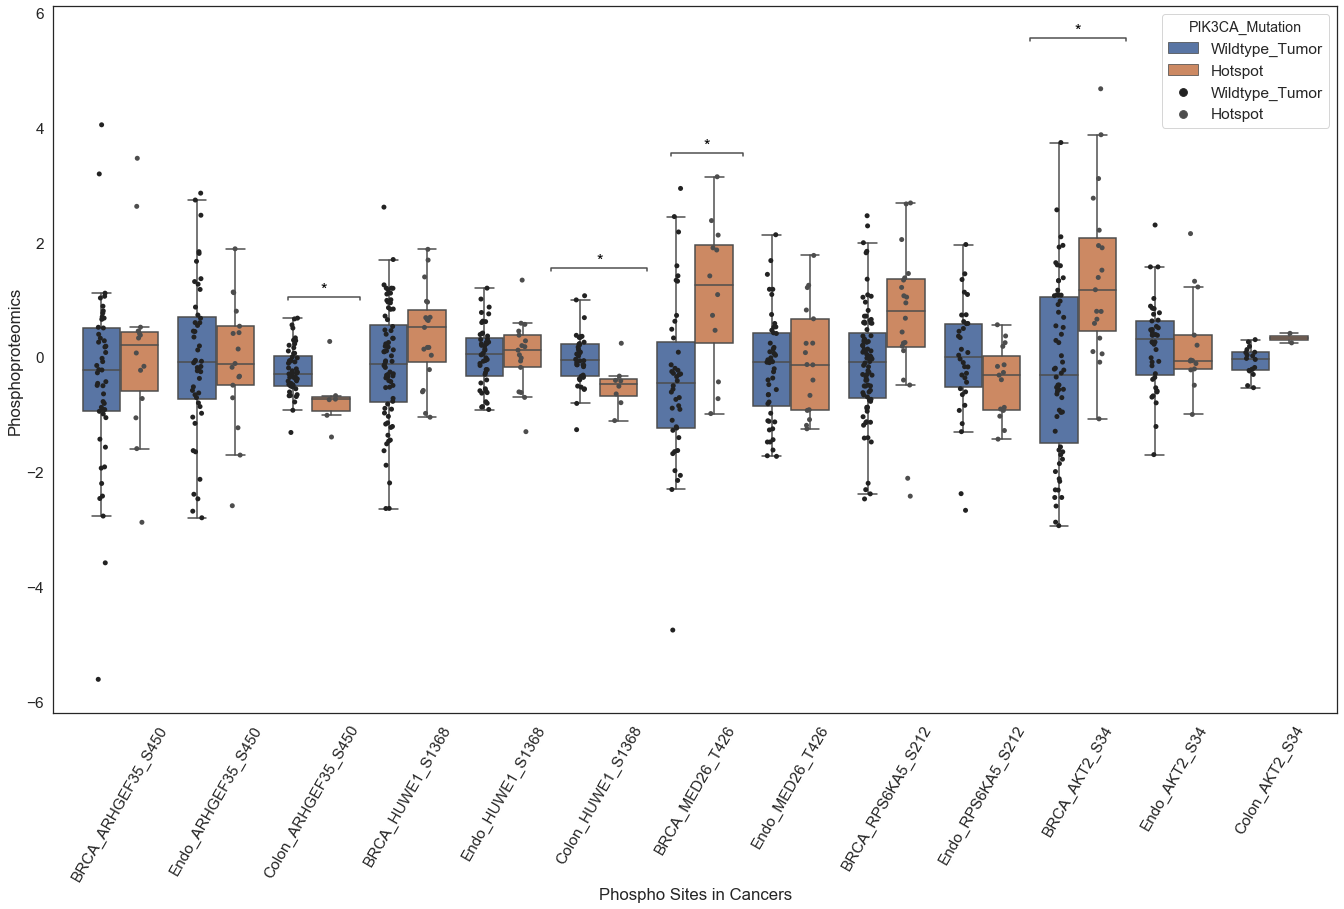

In [151]:
# cis plot
gene = 'PIK3CA'
plt.rcParams['figure.figsize']=(23, 13) #size of plot


sns.set(font_scale = 1.4, style = "white")
boxplot = sns.boxplot(x='cancer_site', y= "Phospho", data = plot_df, hue = 'PIK3CA_Mutation'
                      ,hue_order = ["Wildtype_Tumor", "Hotspot"], order = x_order, showfliers = False)   
#boxplot.set_title('Pancancer cis effect of PIK3CA Missense')
boxplot = sns.stripplot(x='cancer_site', y= "Phospho", data = plot_df, jitter = True, 
                           color = ".3", hue = 'PIK3CA_Mutation',order = x_order, hue_order = ["Wildtype_Tumor", "Hotspot"],dodge = True)
boxplot.set(xlabel = "Phospho Sites in Cancers", ylabel = 'Phosphoproteomics')
boxplot.set_xticklabels(boxplot.get_xticklabels(),rotation=60)

format_pval_annotation('*', 2.5, 1.75, 1) 
format_pval_annotation('*', 4.5, 5.5, 1.5) 
format_pval_annotation('*', 5.75, 6.5, 3.5) 
format_pval_annotation('*', 9.5, 10.5, 5.5) 
plt.show()
plt.clf()
plt.close()

In [152]:

fig = boxplot.get_figure()
fig.savefig("PIK3CA_Figure2B_mertins_akt2.png", dpi = 300,bbox_inches="tight")

In [ ]:
missing = []
checked = []
for gene in phospho_sites:
    if gene in subset_phos_list:
        checked.append(gene)
    else:
        missing.append(gene)
len(missing)
    

In [ ]:
mut_type = br.get_somatic_mutation()
pik_miss = mut_type.loc[mut_type['Gene'] == "PIK3CA"]
hotspot = pik_miss[(pik_miss.Location.str.contains('E542K') | pik_miss.Location.str.contains('E545K') |pik_miss.Location.str.contains('H1047R'))]
hotspot["Mutation"] = "Hotspot"
hotspot.head()
#wt = pik_miss[pik_miss.Mutation.str.contains('Wildtype_Tumor')]
pik_miss

In [ ]:
 #get mutation_tyoe
mut_type = br.get_genotype_all_vars('PIK3CA')

#join proteomics and mutation type
joined = mut_type.join(phos_62)
#select samples containing hotspot mutations
wt_missense_df = joined[joined.Location.str.contains("E542K") | joined.str.contains('E545K') |
                    joined.Mutation.str.contains('H1047R') | joined.Mutation.str.contains('Wildtype_Tumor')]
wt_missense_df = wt_missense_df.drop(columns = ["Mutation_Status", "Location"])
pd.set_option('display.max_columns', None)
mut_type

In [ ]:
test_cols = list(wt_missense_df.columns[1:])
brca2 = wrap_ttest(wt_missense_df, "Mutation",mincount = 20, comparison_columns = test_cols , correction_method="fdr_bh", return_all=True, pval_return_corrected=True)
brca2

In [ ]:
test_cols = list(wt_missense_df.columns[1:])
brca2 = wrap_ttest(wt_missense_df, "Mutation", comparison_columns = test_cols , correction_method="fdr_bh", return_all=True, pval_return_corrected=False)
brca2

# Endo

In [ ]:
phos_e = endo.get_phosphoproteomics(tissue_type="tumor")
phos_62_e = cptac.utils.reduce_multiindex(phos_e, flatten=True)
genefilter = phos_62_e.columns.get_level_values("Name").isin(phospho_sites)
phos_62_e = phos_62_e[phos_62_e.columns[genefilter]]
subset_phos_list_e = phos_62_e.columns.to_list()
phos_62_e

In [ ]:
phos_e = endo.get_phosphoproteomics(tissue_type="tumor")
phos_e_sites = cptac.utils.reduce_multiindex(phos_e, flatten=True)
#filter_col = [col for col in phos_e_sites if col.startswith("HUWE1")]
#filter_col

In [ ]:
missing = []
checked = []
for gene in phospho_sites:
    if gene in subset_phos_list_e:
        checked.append(gene)
    else:
        missing.append(gene)
missing
    

In [ ]:
 #get mutation_tyoe
mut_type_e = endo.get_genotype_all_vars('PIK3CA')

#join proteomics and mutation type
joined_e = mut_type_e.join(phos_62_e)
#select samples containing hotspot mutations
wt_missense_df_e = joined_e[joined_e.Mutation.str.contains("Missense_Mutation") | 
                    joined_e.Mutation.str.contains('Wildtype_Tumor')]
wt_missense_df_e = wt_missense_df_e.drop(columns = ["Mutation_Status", "Location"])
wt_missense_df_e

In [ ]:
test_cols_e = list(wt_missense_df_e.columns[1:])
endo_df = u.wrap_ttest(wt_missense_df_e, "Mutation", comparison_columns = test_cols_e , correction_method="fdr_bh", return_all=True, pval_return_corrected=True)
endo_df.head()

# Colon

In [ ]:
phos_c = col.get_phosphoproteomics(tissue_type="tumor")
phos_62_c = u.reduce_multiindex(df=phos_c, levels_to_drop=["Database_ID"])
phos_62_c = cptac.utils.reduce_multiindex(phos_62_c, flatten=True)
genefilter = phos_62_c.columns.get_level_values("Name").isin(phospho_sites)
phos_62_c = phos_62_c[phos_62_c.columns[genefilter]]
subset_phos_list_c = phos_62_c.columns.to_list()
phos_62_c

In [ ]:
 #get mutation_tyoe
mut_type_c = col.get_genotype_all_vars('PIK3CA')

#join proteomics and mutation type
joined_c = mut_type_c.join(phos_62_c)
#select samples containing hotspot mutations

joined_c = joined_c.replace(r' ', "_", regex = True)
wt_missense_df_c = joined_c[joined_c.Mutation.str.contains("nonsynonymous_SNV") | 
                    joined_c.Mutation.str.contains('Wildtype_Tumor')]
wt_missense_df_c = wt_missense_df_c.drop(columns = ["Mutation_Status", "Location"])
wt_missense_df_c

In [ ]:
test_cols_c = list(wt_missense_df_c.columns[1:])
col_df = u.wrap_ttest(wt_missense_df_c, "Mutation", comparison_columns = test_cols_c , correction_method="fdr_bh", return_all=True, pval_return_corrected=True)
col_df

# Brca studies comparison

In [ ]:
BRCA = pd.merge(brca1_pvals, brca2, on = "Comparison", how = "inner")
BRCA["-log_P_value_Brca1"]= BRCA["P_Value_x"].apply(lambda x: -1*(np.log(x)))
BRCA["-log_P_value_Brca_CPTAC"]= BRCA["P_Value_y"].apply(lambda x: -1*(np.log(x)))

In [ ]:
print ("n = " + str(len(BRCA)))
BRCA.sort_values(by=['-log_P_value_Brca_CPTAC'], ascending=False)

In [ ]:
ax = sns.scatterplot(x="-log_P_value_Brca1", y="-log_P_value_Brca_CPTAC", data=BRCA)

# Brca vs Endo

In [ ]:
brca_endo= pd.merge(brca1_pvals, endo_df, on = "Comparison", how = "inner")
brca_endo["-log_P_value_Brca1"]= brca_endo["P_Value_x"].apply(lambda x: -1*(np.log(x)))
brca_endo["-log_P_value_Endo"]= brca_endo["P_Value_y"].apply(lambda x: -1*(np.log(x)))
print ("n = " + str(len(brca_endo)))
brca_endo.head()

In [ ]:
ax = sns.scatterplot(x="-log_P_value_Brca1", y="-log_P_value_Endo", data=brca_endo)

# Brca vs Colon

In [ ]:
brca_colon = pd.merge(brca1_pvals, col_df, on = "Comparison", how = "inner")
brca_colon["-log_P_value_Brca1"]=brca_colon["P_Value_x"].apply(lambda x: -1*(np.log(x)))
brca_colon["-log_P_value_Colon"]=brca_colon["P_Value_y"].apply(lambda x: -1*(np.log(x)))
print ("n = " + str(len(brca_colon)))
brca_colon.head()

In [ ]:
ax = sns.scatterplot(x="-log_P_value_Brca1", y="-log_P_value_Colon", data=brca_colon)

In [ ]:
gene_site = 'MED26_T426'
plot_df = wt_missense_df[[gene_site,'Mutation']]

# Plot single phosphosite
plt.rcParams['figure.figsize']=(8,5) #size of plot
sns.set(font_scale = 1.2)

boxplot = sns.boxplot(x='Mutation', y=gene_site, data = plot_df, showfliers = False)    
boxplot.set_title('BRCA2 PIK3CA Hotspot Mutation Effect on '+gene_site +' Levels\n')
boxplot = sns.stripplot(x='Mutation', y=gene_site, data = plot_df, jitter = True, 
                           color = ".3", dodge = True)
boxplot.set(xlabel = "\nPIK3CA Mutation Status ", ylabel = 'Phosphoproteomics')

# format legend
handles, labels = boxplot.get_legend_handles_labels()
plt.legend(handles[0:2], labels[0:2])

plt.show()
plt.clf()
plt.close()